# Workflow for a multi-regional energy system

In this application of the FINE framework, a multi-regional energy system is modeled and optimized.

All classes which are available to the user are utilized and examples of the selection of different parameters within these classes are given.

The workflow is structures as follows:
1. Required packages are imported and the input data path is set
2. An energy system model instance is created
3. Commodity sources are added to the energy system model
4. Commodity conversion components are added to the energy system model
5. Commodity storages are added to the energy system model
6. Commodity transmission components are added to the energy system model
7. Commodity sinks are added to the energy system model
8. The energy system model is optimized



# 1. Import required packages and set input data path

The FINE framework is imported which provides the required classes and functions for modeling the energy system. The pandas packages is used for import location and time series specific data. The os package is used for setting the input data path. Matplotlib is used for plotting.

In [1]:
import FINE as fn
import pandas as pd
import os
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
cwd = os.getcwd()
inputDataPath = os.path.join(cwd,"InputData")

# 2. Create an energy system model instance 

The structure of the energy system model is given by the considered locations, commodities, the number of time steps as well as the hours per time step.

The commodities are specified by a unit (i.e. 'GW_electric', 'GW_H2lowerHeatingValue', 'Mio. t CO2/h') which can be given as an energy or mass unit per hour. Furthermore, the cost unit and length unit are specified.

In [3]:
CO2modeling=True
biogasModeling=True
H2modeling=True
transmissionModeling=True
storageModeling=True
RESmodeling=True
RORmodeling=True
PHSmodeling=True
maxCapCCGTCH4modeling=False

locations = {'cluster_0','cluster_7'}
commodities = {'electricity','methane'}
commodityUnitDict = {'electricity': 'GW_el', 'methane': 'GW_CH4_LHV'}
if biogasModeling:
    commodities.add('biogas')
    commodityUnitDict.update({'biogas': 'GW_biogas_LHV'})
if CO2modeling:
    commodities.add('CO2')
    commodityUnitDict.update({'CO2': 'Mio. t CO2/h'})
if H2modeling:
    commodities.add('hydrogen')
    commodityUnitDict.update({'hydrogen': 'GW_H2_LHV'})
numberOfTimeSteps=8760
hoursPerTimeStep=1

CO2_reductionTarget = 0.95
CO2reduction = 366*(1-CO2_reductionTarget)*6/8
CO2reduction

13.725000000000012

In [4]:
commodities, commodityUnitDict

({'CO2', 'biogas', 'electricity', 'hydrogen', 'methane'},
 {'CO2': 'Mio. t CO2/h',
  'biogas': 'GW_biogas_LHV',
  'electricity': 'GW_el',
  'hydrogen': 'GW_H2_LHV',
  'methane': 'GW_CH4_LHV'})

In [5]:
esM = fn.EnergySystemModel(locations=locations, commodities=commodities, numberOfTimeSteps=8760,
                           hoursPerTimeStep=1, commoditiyUnitsDict=commodityUnitDict,
                           costUnit='1e9 Euro', lengthUnit='km')

In [6]:
CO2_reductionTarget = 0.6*6/8

# 3. Add commodity sources to the energy system model

## 3.1. Electricity sources

### Wind onshore

In [7]:
if RESmodeling:
    capacityMax=pd.read_excel(os.path.join(inputDataPath,'SpatialData','Wind','maxCapacityOnshore_GW_el.xlsx'),
                              index_col=0, squeeze=True)
    operationRateMax=pd.read_excel(os.path.join(inputDataPath,'SpatialData','Wind','maxOperationRateOnshore_el.xlsx'))

    esM.add(fn.Source(esM=esM, name='Wind (onshore)', commodity='electricity', hasCapacityVariable=True,
                      operationRateMax=operationRateMax, capacityMax=capacityMax,
                      investPerCapacity=1.1, opexPerCapacity=1.1*0.02, interestRate=0.08,
                      economicLifetime=20))

The locationalEligibility of a component was set based on the given fixed/maximum capacity of the component.


### Wind offshore

In [8]:
if RESmodeling:
    capacityMax=pd.read_excel(os.path.join(inputDataPath,'SpatialData','Wind','maxCapacityOffshore_GW_el.xlsx'),
                              index_col=0, squeeze=True)
    operationRateMax=pd.read_excel(os.path.join(inputDataPath,'SpatialData','Wind','maxOperationRateOffshore_el.xlsx'))

    esM.add(fn.Source(esM=esM, name='Wind (offshore)', commodity='electricity', hasCapacityVariable=True,
                      operationRateMax=operationRateMax, capacityMax=capacityMax,
                      investPerCapacity=2.3, opexPerCapacity=2.3*0.02, interestRate=0.08,
                      economicLifetime=20))

The locationalEligibility of a component was set based on the given fixed/maximum capacity of the component.


### PV

In [9]:
if RESmodeling:
    capacityMax=pd.read_excel(os.path.join(inputDataPath,'SpatialData','PV','maxCapacityPV_GW_el.xlsx'),
                              index_col=0, squeeze=True)
    operationRateMax=pd.read_excel(os.path.join(inputDataPath,'SpatialData','PV','maxOperationRatePV_el.xlsx'))

    esM.add(fn.Source(esM=esM, name='PV', commodity='electricity', hasCapacityVariable=True,
                      operationRateMax=operationRateMax, capacityMax=capacityMax,
                      investPerCapacity=0.65, opexPerCapacity=0.65*0.02, interestRate=0.08,
                      economicLifetime=25))

The locationalEligibility of a component was set based on the given fixed/maximum capacity of the component.


### Exisisting run-of-river hydroelectricity plants

In [10]:
if RESmodeling and RORmodeling:
    capacityFix=pd.read_excel(os.path.join(inputDataPath,'SpatialData','HydroPower','fixCapacityROR_GW_el.xlsx'),
                              index_col=0, squeeze=True)
    operationRateFix=pd.read_excel(os.path.join(inputDataPath,'SpatialData','HydroPower',
                                                'fixOperationRateROR_GW_el.xlsx'))

    esM.add(fn.Source(esM=esM, name='Existing run-of-river plants', commodity='electricity',
                      hasCapacityVariable=True,
                      operationRateFix=operationRateFix, capacityFix=capacityFix,
                      investPerCapacity=0, opexPerCapacity=0.208))

The locationalEligibility of a component was set based on the given fixed/maximum capacity of the component.


## 3.2. Methane (natural gas and biogas)

### Natural gas

In [11]:
esM.add(fn.Source(esM=esM, name='Natural gas purchase', commodity='methane',
                  hasCapacityVariable=False, commodityCost=0.0331*1e-3))

The locationalEligibility of a component is set to 1 (eligible) for all locations.


### Biogas

In [12]:
if biogasModeling:
    operationRateMax=pd.read_excel(os.path.join(inputDataPath,'SpatialData','Biogas',
                                                'biogasPotential_GWh_biogas.xlsx'))

    esM.add(fn.Source(esM=esM, name='Biogas purchase', commodity='biogas', operationRateMax=operationRateMax,
                      hasCapacityVariable=False, commodityCost=0.05409*1e-3))

## 3.3 CO2

### CO2

The CO2 source is required for the case in which it can be mixed with conventional natural gas.

In [13]:
if CO2modeling and biogasModeling:
    esM.add(fn.Source(esM=esM, name='CO2 from enviroment', commodity='CO2',
                      hasCapacityVariable=False, commodityLimitID='CO2 limit',
                      yearlyLimit=CO2reduction))

The locationalEligibility of a component is set to 1 (eligible) for all locations.


# 4. Add conversion components to the energy system model

### Biogas to methane

In [14]:
if CO2modeling and biogasModeling:
    esM.add(fn.Conversion(esM=esM, name='Biogas to methane',
                          commodityConversionFactors={'biogas':-1, 'methane':1, 'CO2':-201*1e-6*0.625},
                          hasCapacityVariable=False))

The locationalEligibility of a component is set to 1 (eligible) for all locations.


### Existing combined cycle gas turbine plants

In [15]:
if maxCapCCGTCH4modeling:
    capacityMax=pd.read_excel(os.path.join(inputDataPath,'SpatialData','NaturalGasPlants',
                                           'existingCombinedCycleGasTurbinePlantsCapacity_GW_el.xlsx'),
                              index_col=0, squeeze=True)
else:
    capacityMax=None

if CO2modeling:
    esM.add(fn.Conversion(esM=esM, name='Existing CCGT plants (methane)',
                          commodityConversionFactors={'electricity':1, 'methane':-1/0.625, 'CO2':201*1e-6/0.625},
                          hasCapacityVariable=True, capacityMax=capacityMax,
                          investPerCapacity=0, opexPerCapacity=0.021, interestRate=0.08,
                          economicLifetime=33))
else:
    esM.add(fn.Conversion(esM=esM, name='Existing CCGT plants (methane)',
                          commodityConversionFactors={'electricity':1, 'methane':-1/0.625},
                          hasCapacityVariable=True, capacityMax=capacityMax,
                          investPerCapacity=0, opexPerCapacity=0.021, interestRate=0.08,
                          economicLifetime=33))

The locationalEligibility of a component is set to 1 (eligible) for all locations.


### New combined cycle gas turbine plants for biogas

In [16]:
if biogasModeling:
    esM.add(fn.Conversion(esM=esM, name='New CCGT plants (biogas)',
                          commodityConversionFactors={'electricity':1, 'biogas':-1/0.635},
                          hasCapacityVariable=True, 
                          investPerCapacity=0.7, opexPerCapacity=0.021, interestRate=0.08,
                          economicLifetime=33))

The locationalEligibility of a component is set to 1 (eligible) for all locations.


### New combined cycly gas turbines for hydrogen

In [17]:
if H2modeling:
    esM.add(fn.Conversion(esM=esM, name='New CCGT plants (hydrogen)',
                          commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.6},
                          hasCapacityVariable=True, 
                          investPerCapacity=0.927, opexPerCapacity=0.021, interestRate=0.08,
                          economicLifetime=33))

The locationalEligibility of a component is set to 1 (eligible) for all locations.


### Electrolyzers

In [18]:
if H2modeling:
    esM.add(fn.Conversion(esM=esM, name='Electrolyzers',
                          commodityConversionFactors={'electricity':-1, 'hydrogen':0.7},
                          hasCapacityVariable=True, 
                          investPerCapacity=0.5, opexPerCapacity=0.5*0.025, interestRate=0.08,
                          economicLifetime=10))

The locationalEligibility of a component is set to 1 (eligible) for all locations.


# 5. Add commodity storages to the energy system model

## 5.1. Electricity storage

### Lithium ion batteries

The self discharge of a lithium ion battery is here described as 3% per month. The self discharge per hours is obtained using the equation (1-$\text{selfDischarge}_\text{hour})^{30*24\text{h}} = 1-\text{selfDischarge}_\text{month}$.

In [19]:
if storageModeling:
    esM.add(fn.Storage(esM=esM, name='Li-ion batteries', commodity='electricity',
                       hasCapacityVariable=True, chargeEfficiency=0.95,
                       dischargeEfficiency=0.95, selfDischarge=1-(1-0.03)**(1/(30*24)), cyclicLifetime=10000, 
                       chargeRate=1, dischargeRate=1, doPreciseTsaModeling=True,
                       investPerCapacity=0.151, opexPerCapacity=0.002, interestRate=0.08,
                       economicLifetime=22))

The locationalEligibility of a component is set to 1 (eligible) for all locations.


## 5.2. Hydrogen storage

### Hydrogen filled salt caverns
The maximum capacity is here obtained by: dividing the given capacity (which is given for methane) by the lower heating value of methane and then multiplying it with the lower heating value of hydrogen.

In [20]:
if H2modeling and storageModeling:
    capacityMax=pd.read_excel(os.path.join(inputDataPath,'SpatialData','GeologicalStorage',
                                           'existingSaltCavernsCapacity_GWh_methane.xlsx'),
                              index_col=0, squeeze=True)*3/10

    esM.add(fn.Storage(esM=esM, name='Salt caverns (hydrogen)', commodity='hydrogen',
                       hasCapacityVariable=True, capacityVariableDomain='continuous',
                       capacityPerPlantUnit=133,
                       chargeRate=1/470.37, dischargeRate=1/470.37, sharedPotentialID='Existing salt caverns',
                       stateOfChargeMin=0.33, stateOfChargeMax=1, capacityMax=capacityMax,
                       investPerCapacity=0.00011, opexPerCapacity=0.00057, interestRate=0.08,
                       economicLifetime=30))

The locationalEligibility of a component was set based on the given fixed/maximum capacity of the component.


## 5.3. Methane storage

### Methane filled salt caverns

In [21]:
if storageModeling and biogasModeling:
    capacityMax=pd.read_excel(os.path.join(inputDataPath,'SpatialData','GeologicalStorage',
                                           'existingSaltCavernsCapacity_GWh_methane.xlsx'),
                              index_col=0, squeeze=True)

    esM.add(fn.Storage(esM=esM, name='Salt caverns (methane)', commodity='methane',
                       hasCapacityVariable=True, capacityVariableDomain='continuous',
                       capacityPerPlantUnit=443,
                       chargeRate=1/470.37, dischargeRate=1/470.37, sharedPotentialID='Existing salt caverns',
                       stateOfChargeMin=0.33, stateOfChargeMax=1, capacityMax=capacityMax,
                       investPerCapacity=0.00004, opexPerCapacity=0.00001, interestRate=0.08,
                       economicLifetime=30))

The locationalEligibility of a component was set based on the given fixed/maximum capacity of the component.


## 5.4 Pumped hydro storage

### Pumped hydro storage

In [22]:
if storageModeling and PHSmodeling:
    capacityFix=pd.read_excel(os.path.join(inputDataPath,'SpatialData','HydroPower',
                                           'fixCapacityPHS_storage_GWh_energyPHS.xlsx'),
                              index_col=0, squeeze=True)

    esM.add(fn.Storage(esM=esM, name='Pumped hydro storage', commodity='electricity',
                       chargeEfficiency=0.88, dischargeEfficiency=0.88,
                       hasCapacityVariable=True, selfDischarge=1-(1-0.00375)**(1/(30*24)),
                       chargeRate=0.16, dischargeRate=0.12, capacityFix=capacityFix,
                       investPerCapacity=0, opexPerCapacity=0.000153))

The locationalEligibility of a component was set based on the given fixed/maximum capacity of the component.


# 6. Add commodity transmission components to the energy system model

## 6.1. Electricity transmission

### AC cables

In [23]:
if transmissionModeling:
    capacityFix=pd.read_excel(os.path.join(inputDataPath,'SpatialData','ElectricGrid',
                                           'ACcableExistingCapacity_GW_el.xlsx'),
                              index_col=0, header=0)

    esM.add(fn.Transmission(esM=esM, name='AC cables', commodity='electricity',
                            hasCapacityVariable=True, capacityFix=capacityFix))

The distances of a component are set to a normalized values of 1.
The locationalEligibility of a component was set based on the given fixed/maximum capacity of the component.


### DC cables

In [24]:
if transmissionModeling:
    capacityFix=pd.read_excel(os.path.join(inputDataPath,'SpatialData','ElectricGrid',
                                           'DCcableExistingCapacity_GW_el.xlsx'),
                              index_col=0, header=0)
    distances=pd.read_excel(os.path.join(inputDataPath,'SpatialData','ElectricGrid',
                                           'DCcableLength_km.xlsx'),
                              index_col=0, header=0)
    efficiency=pd.read_excel(os.path.join(inputDataPath,'SpatialData','ElectricGrid',
                                           'DCcableLosses.xlsx'),
                              index_col=0, header=0)

    esM.add(fn.Transmission(esM=esM, name='DC cables', commodity='electricity', losses=efficiency, distances=distances,
                            hasCapacityVariable=True, capacityFix=capacityFix))

The locationalEligibility of a component was set based on the given fixed/maximum capacity of the component.


## 6.2 Methane transmission

### Methane pipeline

In [25]:
if transmissionModeling:
    eligibility=pd.read_excel(os.path.join(inputDataPath,'SpatialData','Pipelines',
                                           'pipelineIncidence.xlsx'), index_col=0, header=0)
    distances=pd.read_excel(os.path.join(inputDataPath,'SpatialData','Pipelines', 'pipelineIncidence.xlsx'),
                              index_col=0, header=0)

    esM.add(fn.Transmission(esM=esM, name='Pipelines (methane)', commodity='methane', distances=distances,
                            hasCapacityVariable=True, #hasDesignDecisionVariables=True, bigM=300,
                            locationalEligibility=eligibility,
                            investPerCapacity=0.000037, #capexForDesignDecision=0.000314,
                            interestRate=0.08, economicLifetime=40))

## 6.3 Hydrogen transmission

### Hydrogen pipelines

In [26]:
if H2modeling and transmissionModeling:
    eligibility=pd.read_excel(os.path.join(inputDataPath,'SpatialData','Pipelines', 'pipelineIncidence.xlsx'),
                              index_col=0, header=0)
    distances=pd.read_excel(os.path.join(inputDataPath,'SpatialData','Pipelines', 'pipelineIncidence.xlsx'),
                              index_col=0, header=0)

    esM.add(fn.Transmission(esM=esM, name='Pipeline (hydrogen)', commodity='hydrogen', distances=distances,
                            hasCapacityVariable=True, #hasDesignDecisionVariables=True, bigM=300,
                            locationalEligibility=eligibility,
                            investPerCapacity=0.000177, #capexForDesignDecision=0.00033,
                            interestRate=0.08, economicLifetime=40))

# 7. Add commodity sinks to the energy system model

## 7.1. Electricity sinks

### Electricity demand

In [27]:
operationRateFix=pd.read_excel(os.path.join(inputDataPath,'SpatialData','Demands',
                                            'electricityDemand_GWh_el.xlsx'))

esM.add(fn.Sink(esM=esM, name='Electricity demand', commodity='electricity',
                hasCapacityVariable=False, operationRateFix=operationRateFix))

## 7.2. Hydrogen sinks

### Fuel cell electric vehicle (FCEV) demand

In [28]:
if H2modeling:
    FCEV_penetration=0.5
    operationRateFix=pd.read_excel(os.path.join(inputDataPath,'SpatialData','Demands',
                                                'hydrogenDemand_GWh_hydrogen.xlsx'))*FCEV_penetration

    esM.add(fn.Sink(esM=esM, name='Hydrogen demand', commodity='hydrogen',
                      hasCapacityVariable=False, operationRateFix=operationRateFix))

## 7.3. CO2 sinks

### CO2 exiting the system's boundary

In [29]:
if CO2modeling:
    esM.add(fn.Sink(esM=esM, name='CO2 to enviroment', commodity='CO2',
                    hasCapacityVariable=False, commodityLimitID='CO2 limit',
                    yearlyLimit=CO2reduction))

The locationalEligibility of a component is set to 1 (eligible) for all locations.


In [30]:
esM._componentNames

{'AC cables': 'TransmissionModeling',
 'Biogas purchase': 'SourceSinkModeling',
 'Biogas to methane': 'ConversionModeling',
 'CO2 from enviroment': 'SourceSinkModeling',
 'CO2 to enviroment': 'SourceSinkModeling',
 'DC cables': 'TransmissionModeling',
 'Electricity demand': 'SourceSinkModeling',
 'Electrolyzers': 'ConversionModeling',
 'Existing CCGT plants (methane)': 'ConversionModeling',
 'Existing run-of-river plants': 'SourceSinkModeling',
 'Hydrogen demand': 'SourceSinkModeling',
 'Li-ion batteries': 'StorageModeling',
 'Natural gas purchase': 'SourceSinkModeling',
 'New CCGT plants (biogas)': 'ConversionModeling',
 'New CCGT plants (hydrogen)': 'ConversionModeling',
 'PV': 'SourceSinkModeling',
 'Pipeline (hydrogen)': 'TransmissionModeling',
 'Pipelines (methane)': 'TransmissionModeling',
 'Pumped hydro storage': 'StorageModeling',
 'Salt caverns (hydrogen)': 'StorageModeling',
 'Salt caverns (methane)': 'StorageModeling',
 'Wind (offshore)': 'SourceSinkModeling',
 'Wind (onshor

# 8. Optimize energy system model


Clustering time series data with 7 typical periods and 24 time steps per period...
		(2.2815 sec)

Number of typical periods: 7 Number of time steps per periods: 24
Declaring sets, variables and constraints for SourceSinkModeling
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.2031 sec)
Declaring sets, variables and constraints for ConversionModeling
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.0781 sec)
Declaring sets, variables and constraints for StorageModeling
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(2.6722 sec)
Declaring sets, variables and constraints for TransmissionModeling
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.0625 sec)
Declaring shared potential constraint...
		(0.0000 sec)
Declaring commodity balances...
		(0.3594 sec)
Declaring objective function...
		(0.2188 sec)
Academic license - for non-commercial use only
Parameter LogToConsole unchang

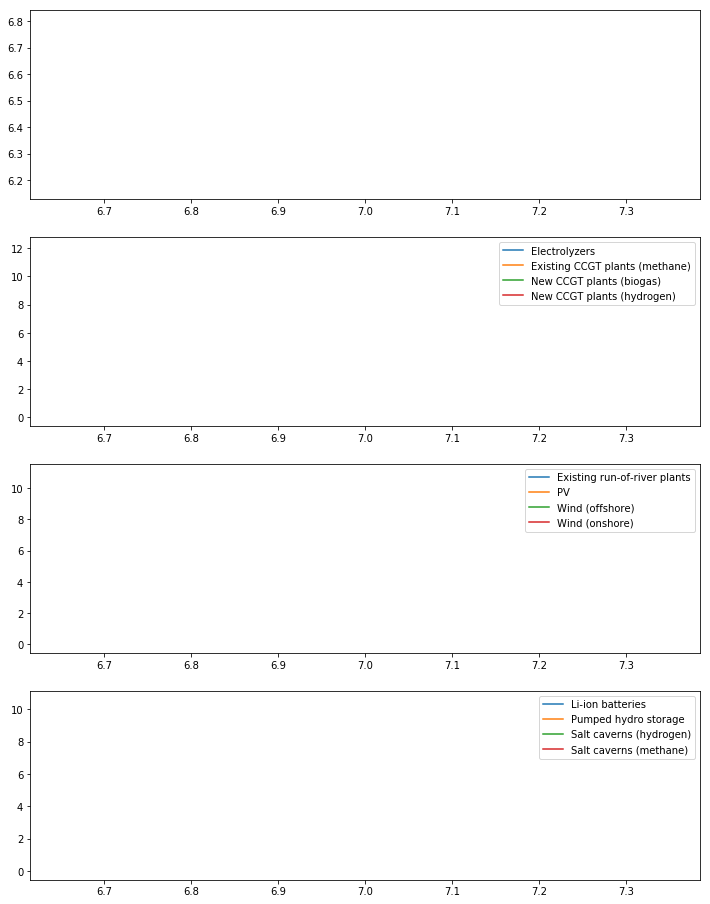

Declaring sets, variables and constraints for SourceSinkModeling
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(10.1886 sec)
Declaring sets, variables and constraints for ConversionModeling
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(3.8754 sec)
Declaring sets, variables and constraints for StorageModeling
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(12.4388 sec)
Declaring sets, variables and constraints for TransmissionModeling
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(3.7817 sec)
Declaring shared potential constraint...
		(0.0000 sec)
Declaring commodity balances...
		(17.2050 sec)
Declaring objective function...
		(7.3914 sec)
Academic license - for non-commercial use only
Parameter LogToConsole unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Parameter OptimalityTol unchanged
   Value: 1e-06  Min: 1e-09  Max: 0.01  Default: 1e-06
Parameter Threads unchanged
   

  85   6.59492619e+00  6.59485336e+00  7.91e-10 1.71e-10  9.87e-11    57s
  86   6.59492256e+00  6.59485354e+00  7.76e-10 1.70e-10  9.72e-11    57s
  87   6.59492007e+00  6.59485450e+00  7.60e-10 1.64e-10  9.46e-11    58s
  88   6.59491820e+00  6.59485525e+00  7.39e-10 1.59e-10  9.19e-11    59s
  89   6.59491894e+00  6.59485746e+00  6.59e-10 1.42e-10  8.39e-11    60s
  90   6.59491890e+00  6.59485830e+00  6.15e-10 1.36e-10  8.04e-11    61s
  91   6.59490839e+00  6.59486011e+00  5.03e-10 1.22e-10  6.79e-11    62s
  92   6.59490421e+00  6.59486147e+00  4.36e-10 1.10e-10  6.04e-11    64s
  93   6.59490212e+00  6.59486417e+00  4.03e-10 8.92e-11  5.41e-11    64s
  94   6.59489956e+00  6.59486658e+00  3.65e-10 7.43e-11  4.75e-11    65s
  95   6.59489599e+00  6.59486959e+00  3.02e-10 5.52e-11  3.84e-11    65s
  96   6.59489093e+00  6.59486998e+00  2.21e-10 5.26e-11  3.07e-11    66s
  97   6.59488952e+00  6.59487002e+00  1.99e-10 5.24e-11  2.86e-11    67s
  98   6.59488938e+00  6.59487056e+00 

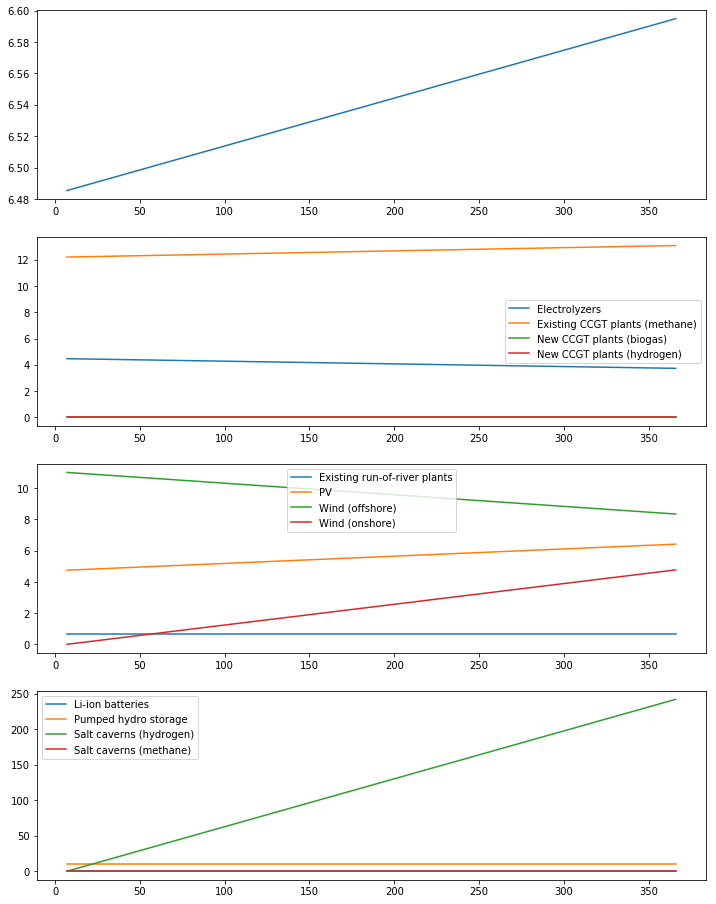

In [31]:
periods = []
TAC = []
cap_conv = []
cap_sosi = []
cap_stor = []

l1=range(4,30,4)
l2=range(30,150,30)
l3=range(150,360,70)
l=[]
l.extend(l1), l.extend(l2), l.extend(l3), l.extend([365])
l = [7]
addPeakMax = ['Electricity demand_operationRate_cluster_0',
              'Electricity demand_operationRate_cluster_7'] 
if H2modeling:
    addPeakMax.extend(['Hydrogen demand_operationRate_cluster_0',
                       'Hydrogen demand_operationRate_cluster_7'])    
#addPeakMax=addPeakMax
#extremePeriodMethod='append', 

for p in l:
    esM.cluster(numberOfTypicalPeriods=p, numberOfTimeStepsPerPeriod=24,
                sortValues=True)
    esM.optimize(timeSeriesAggregation=True, optimizationSpecs='LogToConsole=1 OptimalityTol=1e-6 cuts=3 method=2')
    df1=esM._componentModelingDict["ConversionModeling"]._capacityVariablesOptimum
    df2=esM._componentModelingDict["SourceSinkModeling"]._capacityVariablesOptimum   
    TAC.append(esM._pyM.Obj()), periods.append(p), cap_conv.append(df1), cap_sosi.append(df2)
    conv=pd.concat(cap_conv, keys=periods)
    sosi=None
    if df2 is not None:
        sosi=pd.concat(cap_sosi, keys=periods)     
    if storageModeling:
        df3=esM._componentModelingDict["StorageModeling"]._capacityVariablesOptimum
        cap_stor.append(df3)
        stor=None
        if df3 is not None:
            stor=pd.concat(cap_stor, keys=periods)
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(12,16))
    ax1.plot(periods, TAC)
    for compName in conv.index.get_level_values(1).unique():
        data=conv[conv.index.get_level_values(1)==compName].sum(axis=1)
        ax2.plot(periods, data, label=compName)  
    ax2.legend()
    if sosi is not None:
        for compName in sosi.index.get_level_values(1).unique():
            data=sosi[sosi.index.get_level_values(1)==compName].sum(axis=1)
            ax3.plot(periods, data, label=compName)      
        ax3.legend()
    if storageModeling and stor is not None:
        for compName in stor.index.get_level_values(1).unique():
            data=stor[stor.index.get_level_values(1)==compName].sum(axis=1)
            ax4.plot(periods, data, label=compName)      
        ax4.legend()        
    plt.show()

esM.optimize(timeSeriesAggregation=False, optimizationSpecs='LogToConsole=1 OptimalityTol=1e-6 cuts=3 method=2')
df1=esM._componentModelingDict["ConversionModeling"]._capacityVariablesOptimum
df2=esM._componentModelingDict["SourceSinkModeling"]._capacityVariablesOptimum
TAC.append(esM._pyM.Obj()), periods.append(366), cap_conv.append(df1), cap_sosi.append(df2)
conv=pd.concat(cap_conv, keys=periods)
sosi=None
if df2 is not None:
    sosi=pd.concat(cap_sosi, keys=periods)
if storageModeling:
    df3=esM._componentModelingDict["StorageModeling"]._capacityVariablesOptimum
    cap_stor.append(df3)
    stor=None
    if df3 is not None:
        stor=pd.concat(cap_stor, keys=periods)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(12,16))
ax1.plot(periods, TAC)
for compName in conv.index.get_level_values(1).unique():
    data=conv[conv.index.get_level_values(1)==compName].sum(axis=1)
    ax2.plot(periods, data, label=compName)  
ax2.legend()
if sosi is not None:
    for compName in sosi.index.get_level_values(1).unique():
        data=sosi[sosi.index.get_level_values(1)==compName].sum(axis=1)
        ax3.plot(periods, data, label=compName)      
    ax3.legend()
if storageModeling and stor is not None:
    for compName in stor.index.get_level_values(1).unique():
        data=stor[stor.index.get_level_values(1)==compName].sum(axis=1)
        ax4.plot(periods, data, label=compName)      
    ax4.legend()        
plt.show()

In [32]:
6.59491872599
6.59487771323

6.59487771323

In [33]:
esM._componentModelingDict["SourceSinkModeling"]._capacityVariablesOptimum

,cluster_0,cluster_7
Existing run-of-river plants,NaN,0.655032
PV,0.000000,6.418287
Wind (offshore),8.348206,NaN
Wind (onshore),4.769490,0.000000


In [34]:
esM._componentModelingDict["SourceSinkModeling"]._isBuiltVariablesOptimum

In [35]:
esM._componentModelingDict["SourceSinkModeling"]._operationVariablesOptimum.groupby(level=0).sum().sum(axis=1)

Biogas purchase                     0.000000
CO2 from enviroment                 0.000000
CO2 to enviroment                  13.725000
Electricity demand              81152.040962
Existing run-of-river plants     3211.220222
Hydrogen demand                 11632.881986
Natural gas purchase            68283.582089
PV                               6357.434109
Wind (offshore)                 36122.982261
Wind (onshore)                   9789.483133
dtype: float64

In [36]:
CO2reduction

13.725000000000012

In [37]:
esM._componentModelingDict["ConversionModeling"]._capacityVariablesOptimum

,cluster_0,cluster_7
Electrolyzers,1.567219,2.165494
Existing CCGT plants (methane),6.280207,6.794410
New CCGT plants (biogas),0.000000,0.000000
New CCGT plants (hydrogen),0.000000,0.000000


In [38]:
esM._componentModelingDict["ConversionModeling"]._isBuiltVariablesOptimum

In [50]:
esM._componentModelingDict["ConversionModeling"]._operationVariablesOptimum.sum(axis=1)

Biogas to methane               cluster_0        0.000000
                                cluster_7        0.000000
Electrolyzers                   cluster_0     8429.769455
                                cluster_7     8188.633382
Existing CCGT plants (methane)  cluster_0    22417.822330
                                cluster_7    20259.416476
New CCGT plants (biogas)        cluster_0        0.000000
                                cluster_7        0.000000
New CCGT plants (hydrogen)      cluster_0        0.000000
                                cluster_7        0.000000
dtype: float64

In [40]:
esM._componentModelingDict["StorageModeling"]._capacityVariablesOptimum

,cluster_0,cluster_7
Li-ion batteries,0.123106,0.116413
Pumped hydro storage,NaN,10.605000
Salt caverns (hydrogen),241.838790,NaN
Salt caverns (methane),0.000000,NaN


In [41]:
esM._componentModelingDict["TransmissionModeling"]._operationVariablesOptimum.sum(axis=1)

cluster_0  AC cables            cluster_7    16926.629368
           DC cables            cluster_7     1409.984044
           Pipeline (hydrogen)  cluster_7      409.366870
           Pipelines (methane)  cluster_7        0.000000
cluster_7  AC cables            cluster_0    45401.361779
           DC cables            cluster_0     1865.204379
           Pipeline (hydrogen)  cluster_0     1545.130611
           Pipelines (methane)  cluster_0        0.000000
dtype: float64

In [42]:
esM._componentModelingDict["StorageModeling"]._isBuiltVariablesOptimum   

In [43]:
esM._componentModelingDict["StorageModeling"]._stateOfChargeOperationVariablesOptimum 

0           1           2     \
Li-ion batteries        cluster_0    0.000000    0.000000    0.000000   
                        cluster_7    0.000000    0.000000    0.000000   
Pumped hydro storage    cluster_7    0.000000    0.047048    1.540231   
Salt caverns (hydrogen) cluster_0  179.466078  179.980224  180.494370   
Salt caverns (methane)  cluster_0    0.000000    0.000000    0.000000   

                                         3           4           5     \
Li-ion batteries        cluster_0    0.000000    0.000000    0.000000   
                        cluster_7    0.000000    0.000000    0.000000   
Pumped hydro storage    cluster_7    2.127274    3.038449    4.246411   
Salt caverns (hydrogen) cluster_0  181.008516  181.522662  182.036808   
Salt caverns (methane)  cluster_0    0.000000    0.000000    0.000000   

                                         6           7           8     \
Li-ion batteries        cluster_0    0.035733    0.035731    0.035730   
                        cluster_7    0.000000    0.000000    0.000000   
Pumped hydro storage    cluster_7    4.293436    4.919052    5.145306   
Salt caverns (hydrogen) cluster_0  182.550953  183.065099  183.579245   
Salt caverns (methane)  cluster_0    0.000000    0.000000    0.000000   

                                         9        ...            8751  \
Li-ion batteries        cluster_0    0.035728     ...        0.000000   
                        cluster_7    0.000000     ...        0.000000   
Pumped hydro storage    cluster_7    6.638463     ...        3.018555   
Salt caverns (hydrogen) cluster_0  184.093391     ...      181.684553   
Salt caverns (methane)  cluster_0    0.000000     ...        0.000000   

                                         8752        8753        8754  \
Li-ion batteries        cluster_0    0.000000    0.000000    0.000000   
                        cluster_7    0.000000    0.000000    0.000000   
Pumped hydro storage    cluster_7    1.572403    0.126259    0.126258   
Salt caverns (hydrogen) cluster_0  181.255772  181.019959  180.505813   
Salt caverns (methane)  cluster_0    0.000000    0.000000    0.000000   

                                         8755        8756        8757  \
Li-ion batteries        cluster_0    0.000000    0.000000    0.000000   
                        cluster_7    0.000000    0.000000    0.000000   
Pumped hydro storage    cluster_7    0.126257    0.126257    0.126256   
Salt caverns (hydrogen) cluster_0  179.991667  179.849456  179.335310   
Salt caverns (methane)  cluster_0    0.000000    0.000000    0.000000   

                                         8758        8759        8760  
Li-ion batteries        cluster_0    0.000000    0.000000    0.000000  
                        cluster_7    0.000000    0.000000    0.000000  
Pumped hydro storage    cluster_7    0.126256    0.126255    0.000000  
Salt caverns (hydrogen) cluster_0  179.335310  179.335310  179.466078  
Salt caverns (methane)  cluster_0    0.000000    0.000000    0.000000  

[5 rows x 8761 columns]

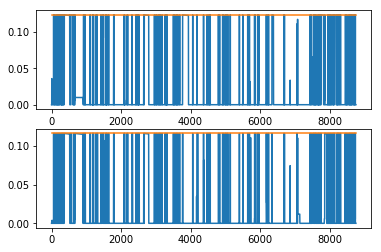

In [44]:
xlim_min=0
xlim_max=8760
des=esM._componentModelingDict["StorageModeling"]._capacityVariablesOptimum
soc=esM._componentModelingDict["StorageModeling"]._stateOfChargeOperationVariablesOptimum 
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(soc.iloc[0,xlim_min:xlim_max])
ax1.plot([xlim_min,xlim_max],[des.iloc[0,0],des.iloc[0,0]])
ax2.plot(soc.iloc[1,xlim_min:xlim_max])
ax2.plot([xlim_min,xlim_max],[des.iloc[0,1],des.iloc[0,1]])

plt.show()

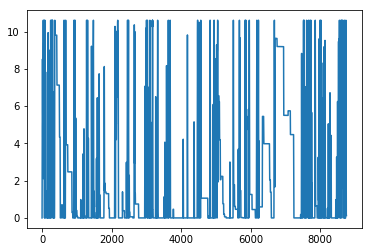

In [45]:
xlim_min=0
xlim_max=8760
des=esM._componentModelingDict["StorageModeling"]._capacityVariablesOptimum
soc=esM._componentModelingDict["StorageModeling"]._stateOfChargeOperationVariablesOptimum 
fig, ax1 = plt.subplots(1,1)
ax1.plot(soc.iloc[2,xlim_min:xlim_max])
ax1.plot([xlim_min,xlim_max],[des.iloc[1,0],des.iloc[1,0]])

plt.show()

In [46]:
esM._componentModelingDict["StorageModeling"]._capacityVariablesOptimum.stack()

Li-ion batteries         cluster_0      0.123106
                         cluster_7      0.116413
Pumped hydro storage     cluster_7     10.605000
Salt caverns (hydrogen)  cluster_0    241.838790
Salt caverns (methane)   cluster_0      0.000000
dtype: float64

In [47]:
esM._componentModelingDict["StorageModeling"]._stateOfChargeOperationVariablesOptimum 

0           1           2     \
Li-ion batteries        cluster_0    0.000000    0.000000    0.000000   
                        cluster_7    0.000000    0.000000    0.000000   
Pumped hydro storage    cluster_7    0.000000    0.047048    1.540231   
Salt caverns (hydrogen) cluster_0  179.466078  179.980224  180.494370   
Salt caverns (methane)  cluster_0    0.000000    0.000000    0.000000   

                                         3           4           5     \
Li-ion batteries        cluster_0    0.000000    0.000000    0.000000   
                        cluster_7    0.000000    0.000000    0.000000   
Pumped hydro storage    cluster_7    2.127274    3.038449    4.246411   
Salt caverns (hydrogen) cluster_0  181.008516  181.522662  182.036808   
Salt caverns (methane)  cluster_0    0.000000    0.000000    0.000000   

                                         6           7           8     \
Li-ion batteries        cluster_0    0.035733    0.035731    0.035730   
                        cluster_7    0.000000    0.000000    0.000000   
Pumped hydro storage    cluster_7    4.293436    4.919052    5.145306   
Salt caverns (hydrogen) cluster_0  182.550953  183.065099  183.579245   
Salt caverns (methane)  cluster_0    0.000000    0.000000    0.000000   

                                         9        ...            8751  \
Li-ion batteries        cluster_0    0.035728     ...        0.000000   
                        cluster_7    0.000000     ...        0.000000   
Pumped hydro storage    cluster_7    6.638463     ...        3.018555   
Salt caverns (hydrogen) cluster_0  184.093391     ...      181.684553   
Salt caverns (methane)  cluster_0    0.000000     ...        0.000000   

                                         8752        8753        8754  \
Li-ion batteries        cluster_0    0.000000    0.000000    0.000000   
                        cluster_7    0.000000    0.000000    0.000000   
Pumped hydro storage    cluster_7    1.572403    0.126259    0.126258   
Salt caverns (hydrogen) cluster_0  181.255772  181.019959  180.505813   
Salt caverns (methane)  cluster_0    0.000000    0.000000    0.000000   

                                         8755        8756        8757  \
Li-ion batteries        cluster_0    0.000000    0.000000    0.000000   
                        cluster_7    0.000000    0.000000    0.000000   
Pumped hydro storage    cluster_7    0.126257    0.126257    0.126256   
Salt caverns (hydrogen) cluster_0  179.991667  179.849456  179.335310   
Salt caverns (methane)  cluster_0    0.000000    0.000000    0.000000   

                                         8758        8759        8760  
Li-ion batteries        cluster_0    0.000000    0.000000    0.000000  
                        cluster_7    0.000000    0.000000    0.000000  
Pumped hydro storage    cluster_7    0.126256    0.126255    0.000000  
Salt caverns (hydrogen) cluster_0  179.335310  179.335310  179.466078  
Salt caverns (methane)  cluster_0    0.000000    0.000000    0.000000  

[5 rows x 8761 columns]

In [48]:
(esM._componentModelingDict["StorageModeling"]._chargeOperationVariablesOptimum.sum(axis=1)/
 esM._componentModelingDict["StorageModeling"]._capacityVariablesOptimum.stack())

Li-ion batteries         cluster_0    143.784029
                         cluster_7    149.820394
Pumped hydro storage     cluster_7    150.038304
Salt caverns (hydrogen)  cluster_0      7.049008
Salt caverns (methane)   cluster_0           NaN
dtype: float64

In [49]:
esM.getCompAttr('Li-ion batteries','_cyclicLifetime')/esM.getCompAttr('Li-ion batteries','_economicLifetime')

cluster_7    454.545455
cluster_0    454.545455
dtype: float64